In [ ]:
%load_ext autoreload
%autoreload 2

# Memory Information and GPU Information



In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.69GB
Available: 11.88GB
Used: 550.71MB
Percentage: 6.4%


In [ ]:
! nvidia-smi

Fri Jun  4 06:14:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Targets

As, we have solved the Over Fitting issue, now let's push the Training by Adding Data Augmentation.  
We have seen from Incorrect classified images, the issue looks like the numbers are having varies degree of orientation and the model is getting confused to predict few numbers, so let's add a Random Rotation.


**Parameters**: Less than 8,000  
**Data Augmentations**: RandomRotation ±15°  
**Regularization**: DropOut  
**LR Scheduler**: None  
**No. of Epochs**: 14  


# Imports

In [ ]:
!git clone https://github.com/EVA6-Group-15/DLUtils.git dlutils

Cloning into 'dlutils'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import dlutils.plotter as plotter
import dlutils.train as train
import dlutils.test as test

# Data

In [ ]:
train_data_ = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor()]))

In [ ]:
plotter.data_stats(train_data_)

Train Statistics
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [ ]:
torch.manual_seed(1)
batch_size = 64

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-15.0,15.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                           shuffle=True, **kwargs)

test_data = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=True, **kwargs)

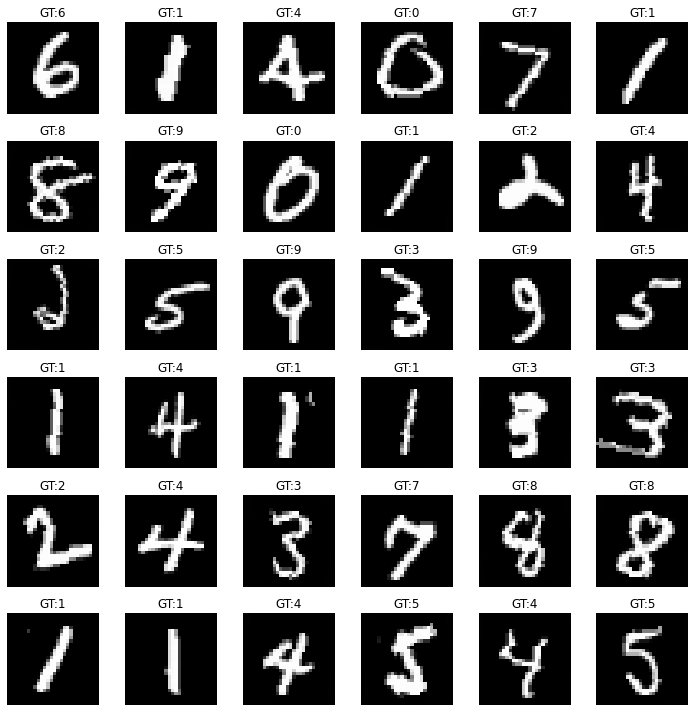

In [ ]:
class_list = [0,1,2,3,4,5,6,7,8,9]
plotter.plot_data_grid(train_loader, mean= (0.1307,), std= (0.3081,), class_list=class_list, ncol=6,nrow=6)

# Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            # 28x28x1 -> 26x26x4
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=8),
            nn.Dropout(0.05),
            # 26x26x4 -> 24x24x8
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=8),
            nn.Dropout(0.05),
            # 24x24x8 -> 12x12x8
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.layer2 =  nn.Sequential(
            # 12x12x8 -> 10x10x16
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            nn.Dropout(0.05),
            # 10x10x12 -> 8x8x12
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            nn.Dropout(0.05),
            # 8x8x812-> 6x6x12
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout(0.05),
            # 6x6x16 -> 4x4x16
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, bias=False)
        )
        
        # 4x4x16 -> 1x1x16
        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1),
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=1)

        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.gap(x)
        x = self.classifier(x)
        x = x.view(-1,10)

        return F.log_softmax(x, dim=1)

In [ ]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]             864
             ReLU-11           [-1, 12, 10, 10]               0
      BatchNorm2d-12           [-1, 12, 10, 10]              24
          Dropout-13           [-1, 12, 10, 10]               0
           Conv2d-14             [-1, 1

# Training

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
trainer = train.Train(model, device, train_loader, optimizer)
tester = test.Test(model, device, test_loader)

for epoch in range(1, 15):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = trainer()
    test_loss, test_acc = tester()
    
    print('TRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


loss=0.19468820095062256 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 45.82it/s]


TRAIN set: Average loss: 0.2994, Train Accuracy: 90.45%
TEST set: Average loss: 0.0523, Test Accuracy: 98.33%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2
TRAIN set: Average loss: 0.0799, Train Accuracy: 97.53%
TEST set: Average loss: 0.0426, Test Accuracy: 98.72%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3
TRAIN set: Average loss: 0.0668, Train Accuracy: 97.90%
TEST set: Average loss: 0.0355, Test Accuracy: 98.89%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4
TRAIN set: Average loss: 0.0596, Train Accuracy: 98.05%
TEST set: Average loss: 0.0390, Test Accuracy: 98.69%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5
TRAIN set: Average loss: 0.0560, Train Accuracy: 98.25%
TEST set: Average loss: 0.0337, Test Accuracy: 98.91%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6
TRAIN set: Average loss: 0.0517, Train Accuracy: 98.31%
TEST set: Average loss: 0.0260, Test Accuracy: 99.17%


# Results

In [ ]:
print('Train Accuracy:', max(trainer.accuracy))
print('Test Accuracy:', max(tester.accuracy))

Train Accuracy: 98.72666666666667
Test Accuracy: 99.36


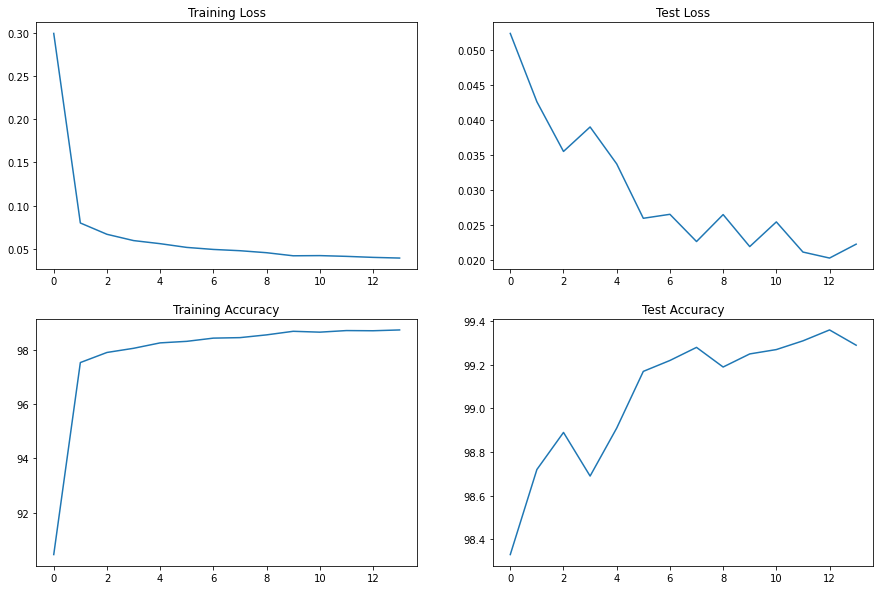

In [ ]:
plotter.plot_loss_acc(trainer.loss, trainer.accuracy, tester.loss, tester.accuracy)

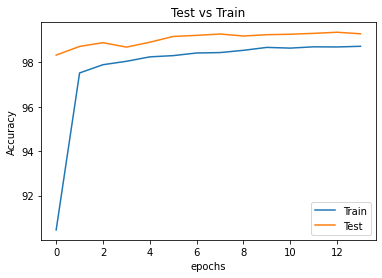

In [ ]:
plotter.plot_combined(trainer.accuracy, tester.accuracy,  x_label='epochs', y_label='Accuracy')

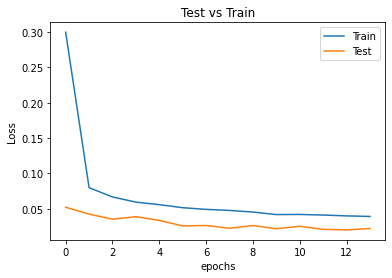

In [ ]:
plotter.plot_combined(trainer.loss, tester.loss,  x_label='epochs', y_label='Loss')

In [ ]:
class_list = [0,1,2,3,4,5,6,7,8,9]
mean= (0.1307,)
std= (0.3081,)
results = plotter.Results(model, test_loader, device, mean, std, class_list)

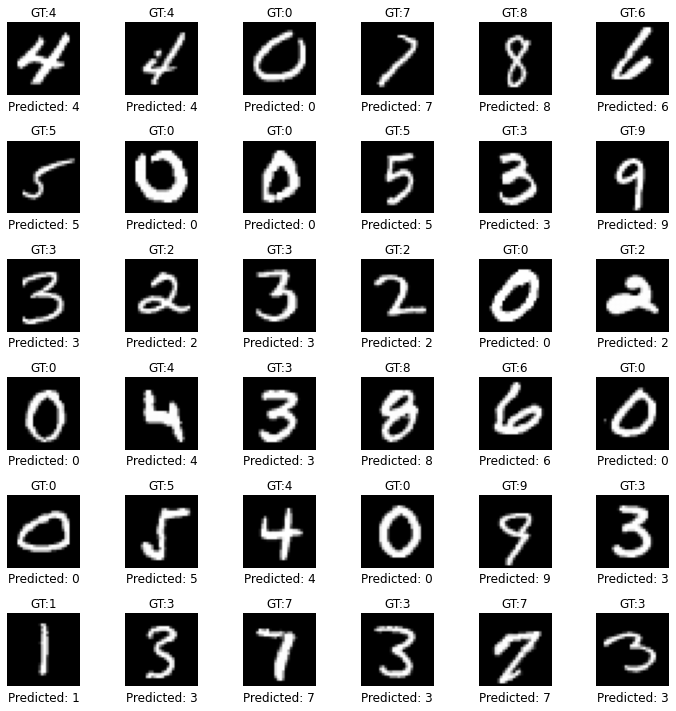

In [ ]:
results.plot_batch(6,6)

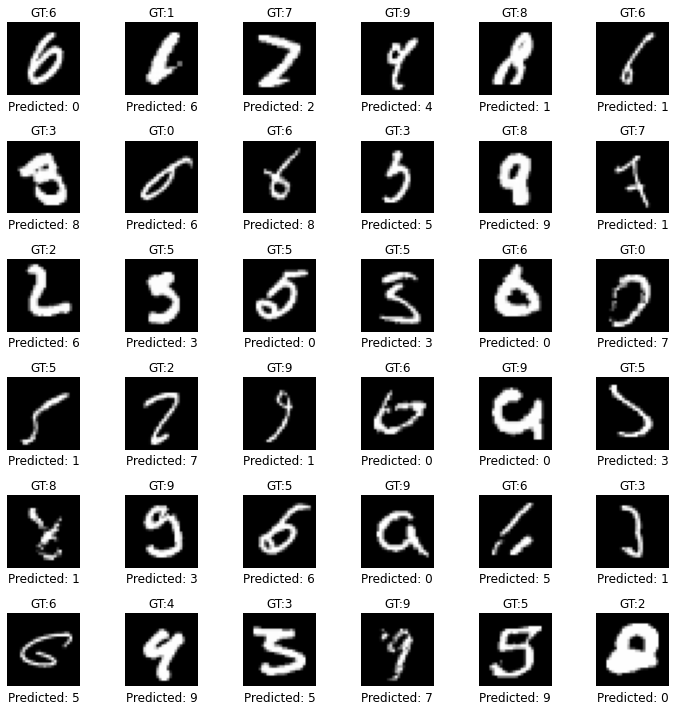

In [ ]:
results.plot_incorrect()

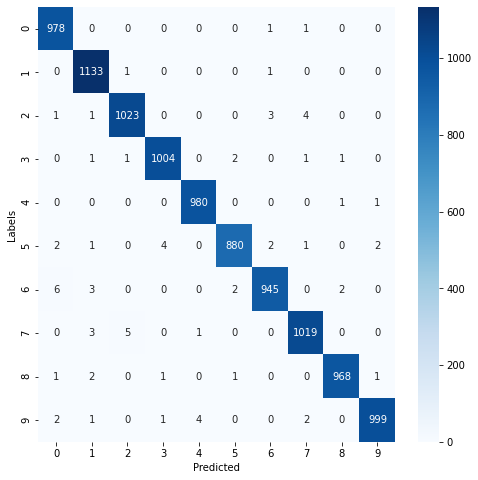

Accuracies of Top 10 Classes in Decreasing Order
Accuracy of class 6 is 98.64
Accuracy of class 5 is 98.65
Accuracy of class 9 is 99.01
Accuracy of class 7 is 99.12
Accuracy of class 2 is 99.13
Accuracy of class 8 is 99.38
Accuracy of class 3 is 99.41
Accuracy of class 0 is 99.80
Accuracy of class 4 is 99.80
Accuracy of class 1 is 99.82


In [ ]:
results.class_accuracy()

# Model Architecture

In [ ]:
!pip3 install hiddenlayer

In [ ]:
import hiddenlayer as hl
model = Net().to('cuda')
network_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]).to('cuda'))
network_graph.save("./images/network_1", "png")

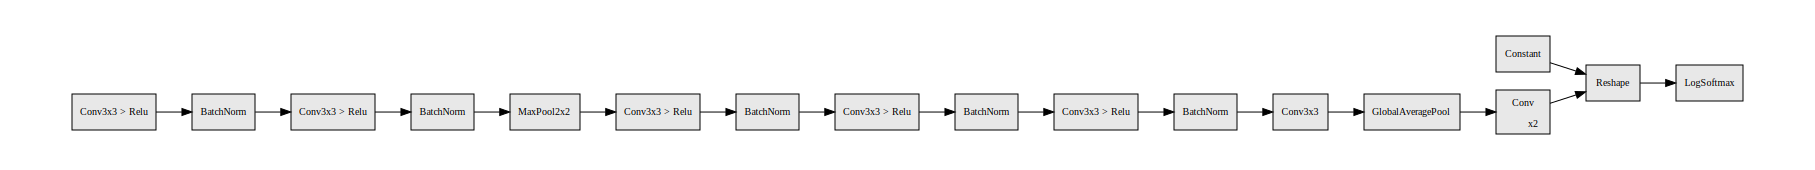

In [ ]:
network_graph

# Acheviements

**Total Parameters Used**: 7,826  
**Train Accuracy**: 98.73  
**Test Accuracy**: **99.36**  
**Consistent From**: Consistent at **99.25-99.3**  
**Data Augmentation**: None


## Analysis

We have used DropOut of 5%, which is like dropping 5 out of 100 weights after each layer and along with that now we are virtually increasing our dataset by adding agumentation, here we are using RandomRotation, which rotates iamges randomly between ±15°.

We have even decreased the training accuracy, and increased test accuracy by using Augmentation, which is a good sign.

But the Test Loss as we observe is not stable and is bouncing from 0.21 to 0.25 and not converging. So the Learning Rate of 0.01 may be too big at this point which is from epoch 6/7.  
So using some kind of Dynamic LR would be effecient.
